In [1]:
import numpy as np
import matplotlib.pyplot as plt

Part 1: Ranking the teams
===

Starting with a matrix of scores, I need to rank the teams. To do this, I want to follow the massey method. I made `make_massey` to build a matrix and scores. I simply send my scores into that, and then I get out M and q. After this I can use a least squares regression to find the rankings. And lastly I made a print function to print out the teams in the proper rankings.

In [2]:
# Input my scores, generated from wolfram alpha page
scores = {("A", "B") : -14, ("A", "C") : -31, ("A", "D") : 18, ("B", "C") : 6, ("B", "D") : -26, ("C", "D") : -12}

**make_massey**

The make_massey method takes a python dictionary of tuples pointed to ints. The tuple is a tuple of 2 strings, one for each team. The int is the score. So the input should be of the form 
> `{...,("team i", "team j"): score, ...}`

The return is M, q, and a dict of teams. The dict is to allow for printing later on

My function will iterate through the keys and values. If a key is not in M, then it is added and my array is resized. Then, for team number i and team number j, I add one to Mii, add one to Mjj, and subtract one from Mij and Mji. This is following the massey method shortcut. I then add my scores to the q. 

Finally, I just replace the last row with ones in M, and the last value in q with 0. Again, this is following the shortcut massey method. 

**print_results**

This method takes the results of a least squares on the massey results, and then will print out the result. It simply loops through and will print out the teams by name and by rank

In [3]:
def make_massey (d):
    teams = {next(iter(d))[0]: 0}   # Start a new dict with first team
    massey = np.zeros((1,1), int)   # a 1x1 matrix for our 1 team
    team_index = 1    # We have the 1 team so far
    q = np.array([0])   # Our first score starts at 0

    for k, v in d.items():
        # One or both may not be contained. lets write two if (add) statements to remedy that
        if (not (k[0] in teams)):
            # First team isn't contained. Add it, resize massey, and set my q
            teams[k[0]] = team_index
            team_index += 1

            rows, cols = massey.shape
            massey = np.vstack((massey, np.zeros((1, cols), int))  )
            massey = np.hstack((massey, np.zeros((rows + 1, cols), int))  )
            q = np.append(q, 0)

        if (not (k[1] in teams)):
            # Now my second team isn't contained. Again, add it, resize massey, set q
            teams[k[1]] = team_index
            team_index += 1

            rows, cols = massey.shape
            massey = np.vstack((massey, np.zeros((1, cols), int))  )
            massey = np.hstack((massey, np.zeros((rows + 1, 1), int))  )
            q = np.append(q, 0)
                
        # Now I know that both are contained. I can go through adding my stuff
        massey[teams[k[0]]][teams[k[0]]] += 1  # Adding one to Mii
        massey[teams[k[1]]][teams[k[1]]] += 1  # Adding one to Mjj
        massey[teams[k[0]]][teams[k[1]]] -= 1  # Want negative times i and j have played
        massey[teams[k[1]]][teams[k[0]]] -= 1  # Want negative times i and j have played

        # Now update my scores
        q[teams[k[0]]] += v
        q[teams[k[1]]] += (-1*v)
    
    # Make sure to set bottom row to all ones, and last q to 0
    rows, cols = massey.shape
    massey[rows - 1, :] = np.ones((1, cols), int)
    q[-1] = 0
    # Returning the teams is needed for later things
    return (massey, q, teams)

# A little helper to get me a key based off a value
def get_key(val, team_d):
    for key, value in team_d.items():
         if val == value:
             return key
 
    return "key doesn't exist"

def print_ranks (r, team_d):
    temp = {}
    rankings = {}
    r = r.tolist()
    #find index of max ranking. Get the team that has that ranking. Print it
    for i, rank in enumerate(r):
        temp[i] = rank
    
    r.sort(reverse=True)

    for i, rank in enumerate(r):
        rankings[rank] = get_key(get_key(rank, temp), team_d)

    # Going through and printing the teams
    i = 1
    for rank, name in rankings.items():
        print(str(i) + ".", name, "has rank = ", rank)
        i += 1


In [11]:
s = {("A", "B") : 8, ("B", "C") : 8, ("C", "A") : 8}
M, q, list = make_massey(s)
r, j, k, l = np.linalg.lstsq(M, q, rcond=None)

# Round r to 5 digits to make it pretty
r = r.round(decimals=5)

# And print the result
print_ranks(r, team_list)

1. A has rank =  0.0


In [5]:
# Find the massey M and q
M, q, team_list = make_massey(scores)

# We do a least squares to get our ranking
r, j, k, l = np.linalg.lstsq(M, q, rcond=None)

# Round r to 5 digits to make it pretty
r = r.round(decimals=5)

# And print the result
print_ranks(r, team_list)



1. D has rank =  5.0
2. C has rank =  3.25
3. B has rank =  -1.5
4. A has rank =  -6.75


Part 2
===

Now, I want to predict the final game. Lets hypothetically say that C and D will be playing. How would I predict the score? Well, use their rankings we just calculated

Question 1 and 2: Predicted winner
---

So to find the predicted winner, I need to find the difference in their scores. The winner has the higher rank, and the point difference will be the difference in their points

In [6]:
drank = 5.0
crank = 3.25
# We can trivially tell d will beat c

print("C will win by", crank-drank, "points.")
print("This means D is predicted to win by", drank-crank, "points")


C will win by -1.75 points.
This means D is predicted to win by 1.75 points


Part 3
===

Now, I want to do a theoretical game between C and D. The most abstracted way to do it would be use a symbolic value for my score. However, I am going to brute force it and calculate the ranking for each value from -50 to 50

Question 1: C and D play
---

Now, C and D play. The score range will be -50 to 50. Lets find the equal point, then anyscore higher then that C will be ranked higher then D, and any score lower D will remain ranked higher then C

In [7]:
scores2 = scores
# Now, go through the range. I want to find when rank[team_list["C"]] == rank[team_list["D"]]
for i in range(-50, 50):
    scores2[("C", "D")] = i
    M2, q2, list = make_massey(scores2)
    r2, j, k, l = np.linalg.lstsq(M2, q2, rcond=None)

    if (r2[list["C"]] >= r2[list["D"]]):
        print("If the score difference is greater then", str(i) + ", then C will be ranked higher")
        break

If the score difference is greater then -8, then C will be ranked higher


In [8]:
scores5 = scores
scores5[("C", "D")] = 10
M5, q5, list = make_massey(scores5)
r5, j, k, l = np.linalg.lstsq(M5, q5, rcond=None)
r5

array([-6.75, -1.5 ,  8.75, -0.5 ])

Question 2: The rankings
---

Regardless of the outcome, A and B will never be effected. So a ranking that is not possible after this game is
> `[D, C, A, B]`

Team A will always be behind B

Question 3: Now, we want to make a new rankings
---

As stated above, the rankings for A and B will not change over time. But for the other rankings, lets go through and plot them all.

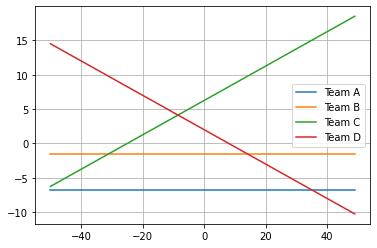

In [9]:
all_rankings = np.empty((0,4))
for i in range(-50, 50):
    scores2[("C", "D")] = i
    M3, q3, list = make_massey(scores2)
    r3, j, k, l = np.linalg.lstsq(M3, q3, rcond=None)
    all_rankings = np.append(all_rankings, np.array([r3]), axis=0)

all_rankings = all_rankings.round(decimals=5)

teamAranks = all_rankings[:,0]
teamBranks = all_rankings[:,1]
teamCranks = all_rankings[:,2]
teamDranks = all_rankings[:,3]

plt.figure()
plt.plot(range(-50, 50), teamAranks, label="Team A")
plt.plot(range(-50, 50), teamBranks, label="Team B")
plt.plot(range(-50, 50), teamCranks, label="Team C")
plt.plot(range(-50, 50), teamDranks, label="Team D")
plt.legend()
plt.grid()
plt.show()


This visualization makes it easy to see the 5 different rankings possible from a point spread of -50 to 50. I will find the rankings for a point differential of -40, -20, 0, 20, and 40. Looking at the graph, it is easy to see that these are in different ranked zones.

In [10]:

for z in range(-40, 60, 20):
    scores[("C", "D")] = z
    print("Ranks at spread of", str(z) + ":")
    M, q, team_list1 = make_massey(scores)
    r, j, k, l = np.linalg.lstsq(M, q, rcond=None)
    r = r.round(decimals=5)
    print_ranks(r, team_list)
    print()


Ranks at spread of -40:
1. D has rank =  12.0
2. B has rank =  -1.5
3. C has rank =  -3.75
4. A has rank =  -6.75

Ranks at spread of -20:
1. D has rank =  7.0
2. C has rank =  1.25
3. B has rank =  -1.5
4. A has rank =  -6.75

Ranks at spread of 0:
1. C has rank =  6.25
2. D has rank =  2.0
3. B has rank =  -1.5
4. A has rank =  -6.75

Ranks at spread of 20:
1. C has rank =  11.25
2. B has rank =  -1.5
3. D has rank =  -3.0
4. A has rank =  -6.75

Ranks at spread of 40:
1. C has rank =  16.25
2. B has rank =  -1.5
3. A has rank =  -6.75
4. D has rank =  -8.0

